## Results and summary

Notebooks 01, 02 and 03 show how to prepare the data, build and train the model. Let's discuss here the results obtained using both `Pytorch` and `Mxnet`. 

In [1]:
import sys
import os
sys.path.append(os.path.abspath('../'))

In [2]:
from utils.plot_utils import plot_anneal_schedule, find_best, plot_loss

In [3]:
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(color_codes=True)
sns.set(context="notebook", font_scale=1., font="serif")

let me remind again the annealing schedule used by the Lian et al in their [paper](https://arxiv.org/pdf/1802.05814.pdf). Basically, they gradually anneal to $\beta = 1$, which is reached at around 80% of the total number of epochs, and record the best anneal parameter ($\beta_{best}$). Then the apply the same annealing schedule but with $\beta_{best}$, i.e. they anneal to $\beta_{best}$ reaching that value at around 80% of the total number of epochs.

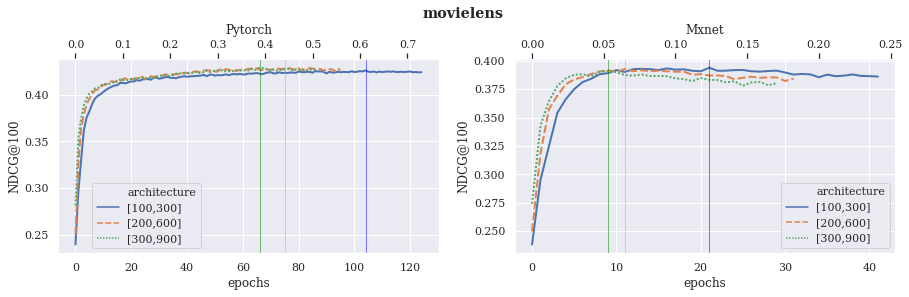

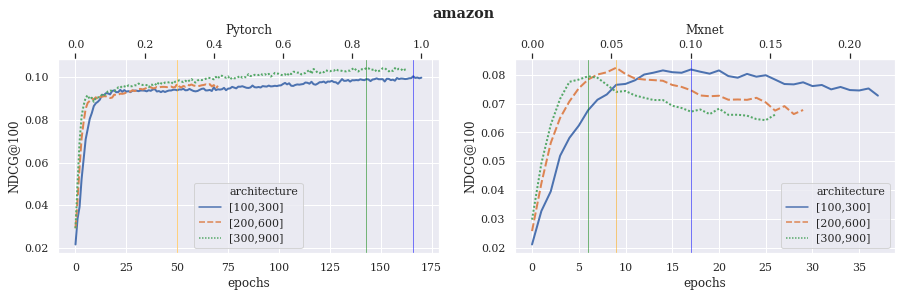

In [4]:
plot_anneal_schedule()

In [5]:
best_results = pd.concat([    
    find_best(dl_frame='pt', model='vae'),
    find_best(dl_frame='pt', model='dae'),
    find_best(dl_frame='mx', model='vae'),
    find_best(dl_frame='mx', model='dae'),
    ]).reset_index(drop=True)

In [7]:
best_results.sort_values(["dataset", "model"]).reset_index(drop=True)

,dataset,dl_frame,model,p_dims,weight_decay,lr,anneal_cap,best_epoch,loss,n100,r20,r50
0,amazon,Pytorch,dae,"[50,150]",0.000,0.001,NA,25,88.394871,0.089841,0.119972,0.182953
1,amazon,Mxnet,dae,"[64,256]",0.000,0.001,NA,18,87.350527,0.090441,0.117494,0.179211
2,amazon,Pytorch,vae,"[300,900]",0.000,0.001,0.8,140,116.761439,0.101168,0.135857,0.202103
3,amazon,Mxnet,vae,"[64,128]",0.000,0.001,0,35,88.415220,0.089808,0.119179,0.181828
4,movielens,Pytorch,dae,"[256, 512]",0.000,0.001,NA,67,348.008255,0.418001,0.386058,0.528727
5,movielens,Mxnet,dae,"[256, 512]",0.000,0.001,NA,102,347.296683,0.419299,0.389156,0.531071
6,movielens,Pytorch,vae,"[200, 600]",0.001,0.001,0.2,180,369.799522,0.424890,0.393835,0.536609
7,movielens,Mxnet,vae,"[200,600]",0.000,0.001,0,118,350.358041,0.419013,0.388713,0.531092


Fig 1 reproduces the same annealing schedule for 3 different architectures and for the Movielens and the Amazon datasets using `Pytorch` and `Mxnet`. During the annealing schedule, $\beta=1$ is reached at 170 epochs (out of 200, i.e. 85%). In addition, I have also used early stopping with a "*patience*" of 20 epochs, which is why none of the experiments reaches the 200 epochs. The vertical lines in the figure indicate the epoch at which the best `NDGC@100` is reached, and the corresponding $\beta$ value.

Table 1 shows the best results I obtained for all the experiments I run, which you can find in this repo in the file `run_experiments.sh`.

At first sight it is apparent how different the two deep learning frames behave. I find `Pytorch` to perform a bit better than `Mxnet` and to be more stable across experiments. This is something that I keep finding every time I use these two frames for the same exercise. For example, [here](https://github.com/jrzaurin/nlp-stuff/tree/master/amazon_reviews_classification_HAN), using Hierarchical Attention networks, or also a few months ago implementing neural collaborative filtering. I actually believe this is due to the fact that I know (or have used) more `Pytorch` than `Mxnet`. Nonetheless, at this stage it is clear for me that I need to do a proper benchmark exercise between these two deep learning libraries. 

Focusing on the results shown in Figure 1, the first apparent result is that the `Mxnet` implementation performs better with little or no regularization. In fact, I have run over 120 experiments and, as shown in Table 1, the best results when using `Mult-VAE` and Mxnet are obtained with no regularization, i.e. a denoising autoencoder with the reparametrization trick. Furthermore, although the results are nearly identical, the best overall metrics with `Mxnet` are obtained using the `Mult-DAE`. 

On the other hand, if we also focus in the differences between datasets, it is first apparent that the metrics are significantly smaller for the Amazon dataset relative to those obtained with the Movielens dataset. This was of course expected since as I mentioned in Notebook 01, the Amazon dataset is 13 times more sparse that the Movielens dataset, i.e. significantly more challenging. In addition, we see that the `Pytorch` implementation shows a very stable behavior for both datasets and architectures, reaching the best `NDCG@10` later in the training epochs in the case of the Amazon dataset. Again this is slightly different in the case of the `Mxnet` implementation, where we see a bit less consistency and the maximum `NDCG@10` being reached very early during training for both datasets.

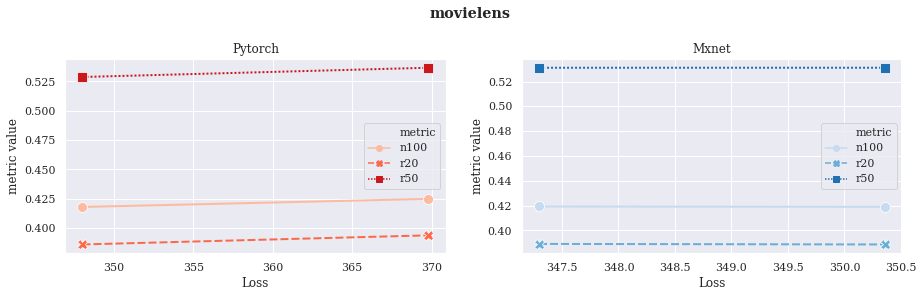

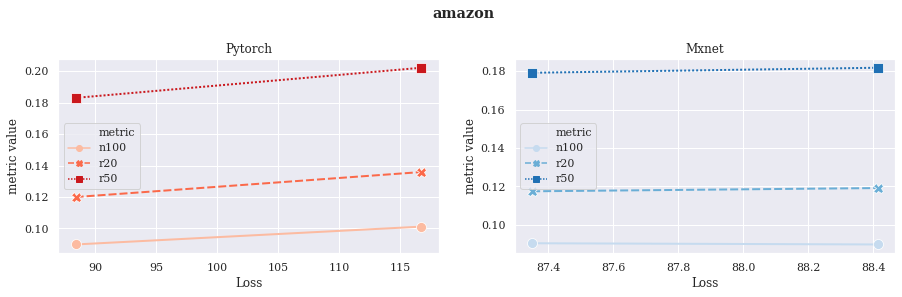

In [8]:
plot_loss(best_results)

Before I end up this exercise I wanted to emphasize a result I have already discussed in the past (see [here](https://github.com/jrzaurin/RecoTour/blob/master/Amazon/neural_graph_cf/Chapter06_results_summary.ipynb)) and that is illustrated in Fig 2. 

Fig 2 shows that, in general, the best ranking metrics do not correspond to the best loss values. In other words, although the reconstruction of the input matrix of clicks is worse, the ranking metrics improve. This is an important and not uncommon results, and something one has to bear in mind when building real world recommendation systems. When building recommendation algorithms we are not interested in achieving the best classification/regression loss, but in producing the best recommendations, which is more related to information retrieval effectiveness, and therefore ranking metrics. For more information on this and many other aspects of recommendation systems, I recommend this [fantastic book](https://www.amazon.co.uk/Recommender-Systems-Textbook-Charu-Aggarwal/dp/3319296574/ref=sr_1_1?crid=2SK7PGNMA59FW&keywords=recommender+systems&qid=1559762483&s=gateway&sprefix=recommender+syste%2Caps%2C153&sr=8-1). Chapter 7 in that book focuses on evaluation metrics. 

And with this, I conclude my experimentation around the `Mult-VAE` with `Pytorch` and `Mxnet`